In [2]:
import pandas as pd
from chaos.results import (
    filter_data,
    extract_best_config_for_analysis,
    format_results_data,
    convert_to_percentage,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To use the Graphein submodule graphein.protein.visualisation, you need to install: pytorch3d 
To do so, use the following command: conda install -c pytorch3d pytorch3d


[09/08/23 11:08:34] WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=183934;file:///home/rankovic/miniconda3/envs/additive_bo/lib/python3.8/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=931763;file:///home/rankovic/miniconda3/envs/additive_bo/lib/python3.8/site-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

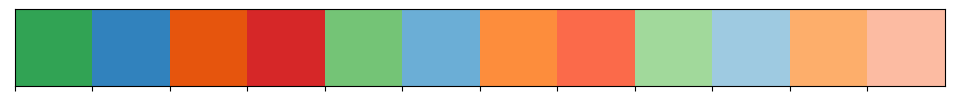

In [3]:
pal_20_c = sns.color_palette(palette="tab20c")
pal_20_c = [x for i, x in enumerate(pal_20_c) if (i + 1) % 4 != 0]
sorted_pal_20_c = (
    pal_20_c[6:9]
    + pal_20_c[0:3]
    + pal_20_c[3:6]
    + sns.color_palette("Reds_r", n_colors=3)
)
pal_4_sorted = [sorted_pal_20_c[i] for i in [0, 3, 6]] + [
    sns.color_palette("tab20", n_colors=20)[6]
]
sns.set_palette(pal_4_sorted + sorted_pal_20_c[1::3] + sorted_pal_20_c[2::3])
full_palette = pal_4_sorted + sorted_pal_20_c[1::3] + sorted_pal_20_c[2::3]
sns.palplot((full_palette))



# Analysis of BO results on Additives dataset

In [4]:
data = pd.read_csv("../report/additives_summary.csv")
history_data = pd.read_csv("../report/additives_history.csv")
data = format_results_data(data)

We are interested in evaluting both the surrogate model fit metrics as well as how different configuration of parameters like 

In [5]:
# Performance metrics list
performance_metrics = [
    "train/r2",
    "valid/r2",
    "train/msll",
    "valid/msll",
    "top_1_count",
    "top_3_count",
    "top_5_count",
    "top_10_count",
    "average_similarity",
    "quantile_99_count",
    "quantile_95_count",
]

In [6]:
percentage_metrics = [
    "top_1_count",
    "top_3_count",
    "top_5_count",
    "top_10_count",
    "quantile_99_count",
    "quantile_95_count",
    "quantile_90_count",
    "quantile_75_count",
]

In [7]:
for metric in percentage_metrics:
    data[metric] = data.apply(
        lambda x: convert_to_percentage(x, metric), axis=1
    )

In [8]:
# List of metrics to analyze
metrics_to_analyze = [
    "train/r2",
    "valid/r2",
    "top_1_count",
    "top_5_count",
    "top_10_count",
    "quantile_99_count",
    "average_similarity",
    "likelihood.noise_covar.noise",
]

display_metrics = [
    "Train R2",
    "Val. R2",
    "Top 1 [%]",
    "Top 5 [%]",
    "Top 10 [%]",
    "99th quantile [%]",
    "Avg. data similarity",
    "Likelihood noise",
]

The following cell filters out results by 

In [9]:
data.rename(columns=dict(zip(metrics_to_analyze, display_metrics)), inplace=True)
data['init'].replace({'true_random': 'random'}, inplace=True)


In [10]:
base_filters = {
    "kernel": ["Linear", "Matern", "Tanimoto"],
    "init": ["random", "kmeans", "maxmin"],
    "acquisition": ["ucb", "ei"],
    "data.data_path": "data/additives/additive_rxn_screening_plate_1.csv",
}

representations_config = [
    {"name": "drfp", "columns": ["bond_radius", "n_bits"]},
    {"name": "rxnfp", "columns": ["normalize"]},
    {"name": "fingerprints", "columns": ["bond_radius", "n_bits"]},
    {"name": "fragprints", "columns": ['n_bits', 'bond_radius']},
    {"name": "xtb", "columns": []},
    {"name": "cddd", "columns": []},
    {"name": "chemberta", "columns": []},
    {"name": "mqn", "columns": []},
    {"name": "ohe", "columns": []},
]

In [11]:
def extract_filtered_data(data, base_filters, metrics_to_analyze, main_metric, config_list, category):
    best_config_results = {}
    filtered_dataframes = {}
    
    for config in config_list:
        current_category = config["name"]
        
        # Filter data
        filtered_data = filter_data(data, base_filters, {category: current_category})
        
        # Extract best configuration for this category
        best_config = extract_best_config_for_analysis(
            filtered_data,
            category,
            metrics_to_analyze,
            config["columns"],
            {category: current_category},
        )
        
        filtered_dataframes[current_category] = filter_data(
            filtered_data, best_config[main_metric]["params"]
        )
        
        best_config_results[current_category]=best_config
    combined_data = pd.concat(filtered_dataframes)
    
    return best_config_results, filtered_dataframes, combined_data

best_config_results, filtered_dataframes, combined_data = extract_filtered_data(
    data, base_filters, display_metrics, "Top 5 [%]", representations_config, 'representation'
)


In [12]:
best_config_results['drfp']

{'Train R2': {'params': {'bond_radius': 3, 'n_bits': 512},
  'value': 0.8668261613627727},
 'Val. R2': {'params': {'bond_radius': 3, 'n_bits': 512},
  'value': 0.006554506012307557},
 'Top 1 [%]': {'params': {'bond_radius': 7, 'n_bits': 512},
  'value': 0.3055555555555556},
 'Top 5 [%]': {'params': {'bond_radius': 7, 'n_bits': 512},
  'value': 0.33055555555555555},
 'Top 10 [%]': {'params': {'bond_radius': 7, 'n_bits': 512},
  'value': 0.24916666666666668},
 '99th quantile [%]': {'params': {'bond_radius': 7, 'n_bits': 512},
  'value': 0.3138888888888889},
 'Avg. data similarity': {'params': {'bond_radius': 7, 'n_bits': 256},
  'value': 0.46143190197798034},
 'Likelihood noise': {'params': {'bond_radius': 7, 'n_bits': 256},
  'value': 0.5598877089542793}}

In [13]:
combined_data.shape

(2939, 85)

In [264]:
combined_data.to_csv(
    "../data/combined_data.csv",
    index=False,
)

In [14]:
representations = combined_data['representation'].unique()
init_strategies = combined_data['init'].unique()
kernels = combined_data['kernel'].unique()
acqs = combined_data['acquisition'].unique()

## Analysis of reaction representations

In [15]:
main_metric = 'Top 5 [%]'

In [16]:
representation_performance = combined_data.groupby("representation")[
    display_metrics
].describe()

representation_performance.columns = [
    "_".join(col).strip() for col in representation_performance.columns.values
]

representation_performance_reset = representation_performance.reset_index()

representation_performance_sorted_mean = representation_performance_reset.sort_values(
    by=[f"{main_metric}_mean"], ascending=False
)

representation_performance_sorted_mean[["representation", f"{main_metric}_mean"]]

,representation,Top 5 [%]_mean
2,drfp,0.330556
4,fragprints,0.245000
3,fingerprints,0.220556
0,cddd,0.152778
7,rxnfp,0.090251
8,xtb,0.086667
5,mqn,0.054444
6,ohe,0.020000
1,chemberta,0.012778


## Kernel influence

In [17]:
kernel_performance = combined_data.groupby(["kernel"])[display_metrics].describe()

# Resetting the multi-index on columns
kernel_performance.columns = [
    "_".join(col).strip() for col in kernel_performance.columns.values
]

# Resetting the index
kernel_performance_reset = kernel_performance.reset_index()

# Sorting the data for better visualization
kernel_performance_sorted = kernel_performance_reset.sort_values(
    by=[f"{main_metric}_mean"], ascending=False
)

kernel_performance_sorted[["kernel", f"{main_metric}_mean"]]

,kernel,Top 5 [%]_mean
1,Matern,0.211849
2,Tanimoto,0.144082
0,Linear,0.083673


## Initialization influence

In [18]:
init_performance = combined_data.groupby(["init"])[display_metrics].describe()

# Resetting the multi-index on columns
init_performance.columns = [
    "_".join(col).strip() for col in init_performance.columns.values
]

# Resetting the index
init_performance_reset = init_performance.reset_index()

# Sorting the data for better visualization
init_performance_sorted = init_performance_reset.sort_values(
    by=[f"{main_metric}_mean"], ascending=False
)

init_performance_sorted[["init", f"{main_metric}_mean"]]

,init,Top 5 [%]_mean
0,kmeans,0.181667
2,random,0.136863
1,maxmin,0.121585


## Acquisition influence

In [19]:
acq_performance = combined_data.groupby(["acquisition"])[display_metrics].describe()

# Resetting the multi-index on columns
acq_performance.columns = [
    "_".join(col).strip() for col in acq_performance.columns.values
]

# Resetting the index
acq_performance_reset = acq_performance.reset_index()

# Sorting the data for better visualization
acq_performance_sorted = acq_performance_reset.sort_values(
    by=[f"{main_metric}_mean"], ascending=False
)

acq_performance_sorted[["acquisition", f"{main_metric}_mean"]]

,acquisition,Top 5 [%]_mean
1,ucb,0.163867
0,ei,0.128423


## Generating Table 2 from the paper 

In [20]:
metric_names_for_table = ["Top 1 [%]", "Top 5 [%]", "Val. R2"]
desired_columns = [
    item
    for sublist in [(f"{metric}_mean", f"{metric}_std") for metric in metric_names_for_table]
    for item in sublist
]

acq_performance_formatted = acq_performance_sorted[desired_columns]
acq_performance_formatted.head()

acq_performance_formatted = acq_performance_sorted[["acquisition"] + desired_columns].copy()
init_performance_formatted = init_performance_sorted[["init"] + desired_columns].copy()
kernel_performance_formatted = kernel_performance_sorted[["kernel"] + desired_columns].copy()

for metric_name in metric_names_for_table:
    acq_performance_formatted[metric_name] = acq_performance_formatted.apply(
        lambda row: f"{row[f'{metric_name}_mean']:.2f} ± {row[f'{metric_name}_std']:.2f}", axis=1
    )
    init_performance_formatted[metric_name] = init_performance_formatted.apply(
        lambda row: f"{row[f'{metric_name}_mean']:.2f} ± {row[f'{metric_name}_std']:.2f}", axis=1
    )
    kernel_performance_formatted[metric_name] = kernel_performance_formatted.apply(
        lambda row: f"{row[f'{metric_name}_mean']:.2f} ± {row[f'{metric_name}_std']:.2f}", axis=1
    )

kernel_performance_formatted["Type"] = "Kernel"
init_performance_formatted["Type"] = "Initialisation"
acq_performance_formatted["Type"] = "Acquisition"

combined_performance_hierarchy = pd.concat(
    [
        kernel_performance_formatted.rename(columns={"kernel": "Parameter"}),
        init_performance_formatted.rename(columns={"init": "Parameter"}),
        acq_performance_formatted.rename(columns={"acquisition": "Parameter"}),
    ]
)[["Type", "Parameter"] + metric_names_for_table]

combined_performance_hierarchy["Type"] = np.where(
    combined_performance_hierarchy["Type"].duplicated(),
    "",
    combined_performance_hierarchy["Type"],
)
combined_performance_hierarchy = combined_performance_hierarchy.reset_index(drop=True)

In [21]:
latex_table_percentage = combined_performance_hierarchy.style.to_latex()


In [22]:
combined_performance_hierarchy

,Type,Parameter,Top 1 [%],Top 5 [%],Val. R2
0,Kernel,Matern,0.25 ± 0.44,0.21 ± 0.31,-0.05 ± 0.19
1,,Tanimoto,0.08 ± 0.28,0.14 ± 0.23,-0.04 ± 0.18
2,,Linear,0.02 ± 0.13,0.08 ± 0.14,0.03 ± 0.15
3,Initialisation,kmeans,0.14 ± 0.35,0.18 ± 0.27,-0.01 ± 0.17
4,,random,0.10 ± 0.30,0.14 ± 0.23,-0.01 ± 0.15
5,,maxmin,0.11 ± 0.31,0.12 ± 0.21,-0.05 ± 0.19
6,Acquisition,ucb,0.13 ± 0.33,0.16 ± 0.25,-0.06 ± 0.19
7,,ei,0.11 ± 0.31,0.13 ± 0.23,0.02 ± 0.15


## Representations comparison

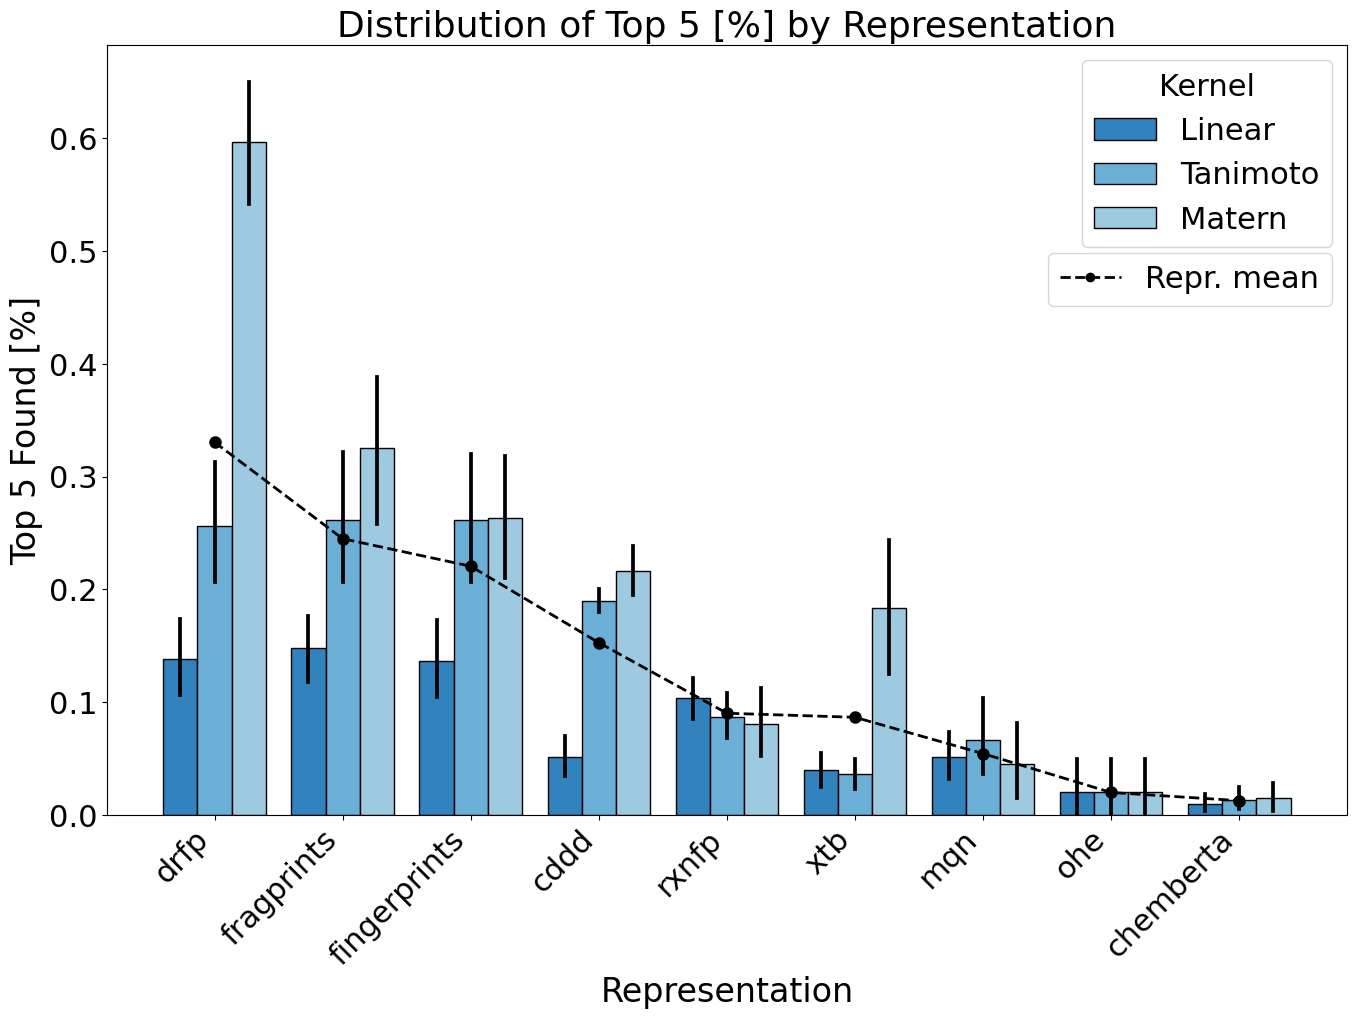

In [23]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

representation_avg = combined_data.groupby('representation')[main_metric].mean().sort_values(ascending=False)
unique_representations = combined_data['representation'].unique()
unique_kernels = combined_data['kernel'].unique()
plt.figure(figsize=(16, 10))

ax1 = plt.gca()

bar = sns.barplot(data=combined_data, x='representation', y=main_metric, hue="kernel", order=representation_avg.index, 
            palette=sorted_pal_20_c[3:6], errorbar='ci', estimator=np.mean, edgecolor='black', errcolor='black', saturation=1, alpha=1, ax=ax1)

# Line plot for average representation performance
ax1.plot(representation_avg.index, representation_avg.values, color='black', marker='o', linestyle='--', linewidth=2, markersize=8, label='Representation mean')


title_fontsize = 26
axis_label_fontsize = 24
tick_label_fontsize = 22
legend_fontsize = 22

ax1 = plt.gca()

legend_elements_kernels = []
for color, kernel in zip(sorted_pal_20_c[3:6], combined_data['kernel'].unique()):
    legend_elements_kernels.append(Patch(facecolor=color, edgecolor='black', label=kernel))
legend_elements_rep_mean = [Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Repr. mean', marker='o')]

legend1 = ax1.legend(title="Kernel", handles=legend_elements_kernels, loc='upper right', bbox_to_anchor=(1, 1), fontsize=legend_fontsize, title_fontsize=legend_fontsize)

ax1.add_artist(legend1)
ax1.legend(handles=legend_elements_rep_mean, loc='upper right', bbox_to_anchor=(1, 0.75), fontsize=legend_fontsize)
ax1.set_xticklabels(representation_performance_sorted_mean['representation'], rotation=45, ha="right", fontsize=tick_label_fontsize)
ax1.set_title(f"Distribution of {main_metric.replace('_', ' ').title()} by Representation", fontsize=title_fontsize)
ax1.set_ylabel('Top 5 Found [%]', fontsize=axis_label_fontsize)
ax1.set_xlabel('Representation', fontsize=axis_label_fontsize)
ax1.tick_params(axis='x', labelrotation=45)
ax1.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

# plt.tight_layout()
plt.savefig('../report/figures/representations-comparison-v2.png', dpi=300, bbox_inches='tight')

plt.show()

## BO paths with Fixed parameters for each representation: Matern, UCB, kmeans

In [24]:
bo_paths_data = filter_data(
    data, {"kernel": "Matern", "acquisition": "ucb", "init": "kmeans"}
)

In [25]:
def add_bo_path_to_plot(
    run_ids,
    metric,
    history_data,
    label,
    color=None,
    ax=None,
    alpha=0.1,
    lw=2.5,
    linestyle="-",
    scale_to=None,
):
    """
    Add a BO path to the existing plot based on run IDs.

    Parameters:
    - run_ids: list of run IDs to consider for the BO path
    - metric: the metric to plot
    - history_data: DataFrame containing the history data
    - label: label for the line plot
    - color: optional color for the line
    """
    # Filter data based on run_ids
    filtered_data = history_data[history_data["run_id"].isin(run_ids)]
    y_data = filtered_data[metric]
    if scale_to:
        min_val = y_data.min()
        max_val = y_data.max()
        min_scale, max_scale = scale_to
        y_data = ((y_data - min_val) / (max_val - min_val)) * (
            max_scale - min_scale
        ) + min_scale

    # Add the line to the plot
    ax = sns.lineplot(
        data=filtered_data,
        x="epoch",
        y=y_data,
        errorbar="ci",
        err_style="band",
        estimator="mean",
        label=label,
        color=color,
        ax=ax,
        alpha=1,
        lw=lw,
        linestyle=linestyle,
        err_kws={"alpha": alpha, "interpolate": True},
    )

    ax.grid(True, linestyle="--", alpha=0.7, which="both")

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

/tmp/ipykernel_3013500/3871609194.py:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


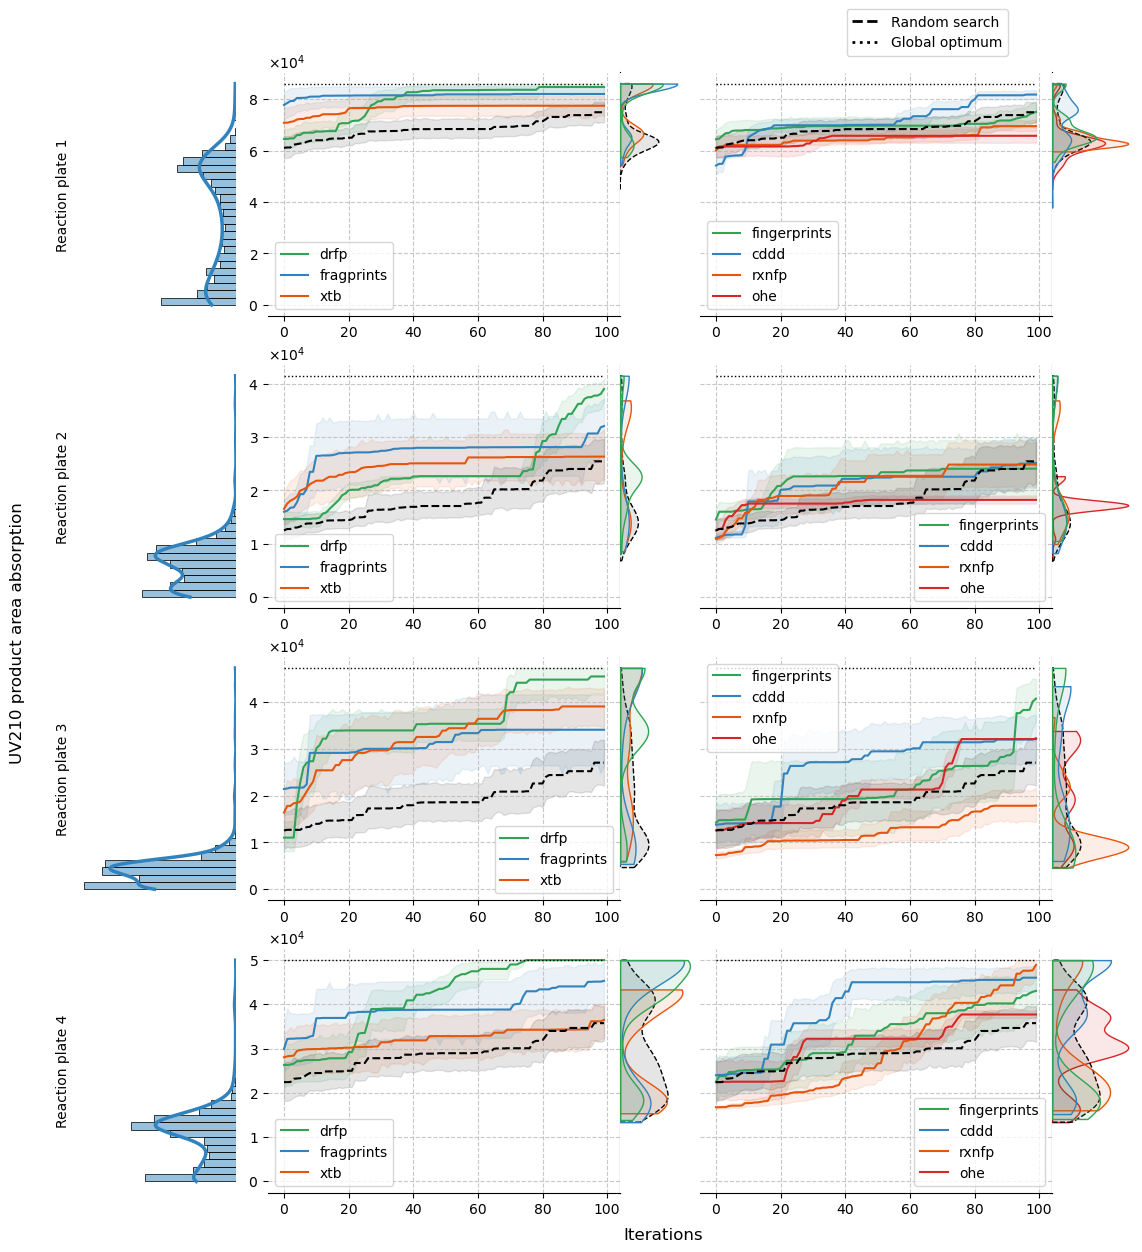

In [26]:
n_cols = 6
n_rows = 4
representations = ["drfp", "fragprints", "cddd", "xtb", "rxnfp", "fingerprints"]

representations_plot_1 = ["drfp", "fragprints", "xtb", ""]
representations_plot_2 = ["fingerprints", "cddd", "rxnfp", ""]
line_styles = ["-", "-", "-", "-"]

fig, ax = plt.subplots(
    n_rows,
    n_cols,
    figsize=(13.2, 14),
    gridspec_kw={
        "width_ratios": [1, 0.2, 2.2, 0.5, 2.2, 0.5],
        "hspace": 0.2,
        "wspace": 0,
    },
)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)


for i in range(n_rows):
    ax[i, 0].sharey(ax[i, 1])
    ax[i, 1].sharey(ax[i, 2])
    ax[i, 2].sharey(ax[i, 3])
    ax[i, 3].sharey(ax[i, 4])
    ax[i, 5].sharey(ax[i, 4])


for i in range(n_rows):
    ax[i, 0].spines["right"].set_visible(False)
    ax[i, 0].spines["left"].set_visible(False)
    ax[i, 0].spines["top"].set_visible(False)
    ax[i, 0].spines["bottom"].set_visible(False)
    ax[i, 0].xaxis.set_visible(False)

    ax[i, 1].yaxis.set_visible(False)
    ax[i, 1].xaxis.set_visible(False)
    ax[i, 1].set_ylabel("")
    ax[i, 1].spines["top"].set_visible(False)
    ax[i, 1].spines["bottom"].set_visible(False)
    ax[i, 1].spines["right"].set_visible(False)
    ax[i, 1].spines["left"].set_visible(False)

    ax[i, 2].spines["left"].set_visible(False)
    ax[i, 2].spines["top"].set_visible(False)

    ax[i, 3].yaxis.set_visible(False)
    ax[i, 3].xaxis.set_visible(False)
    ax[i, 3].set_ylabel("")
    ax[i, 3].spines["top"].set_visible(False)
    ax[i, 3].spines["bottom"].set_visible(False)
    ax[i, 3].spines["right"].set_visible(False)
    ax[i, 3].spines["left"].set_visible(False)

    ax[i, 4].set_ylabel("")
    ax[i, 4].spines["top"].set_visible(False)
    ax[i, 4].spines["left"].set_visible(False)

    ax[i, 5].yaxis.set_visible(False)
    ax[i, 5].xaxis.set_visible(False)
    ax[i, 5].set_ylabel("")
    ax[i, 5].spines["top"].set_visible(False)
    ax[i, 5].spines["bottom"].set_visible(False)
    ax[i, 5].spines["right"].set_visible(False)
    ax[i, 5].spines["left"].set_visible(False)


_, _, bo_paths_data = extract_filtered_data(
    data,
    {"kernel": "Matern", "acquisition": "ucb", "init": "kmeans"},
    display_metrics,
    "Top 5 [%]",
    representations_config[:-1],
    "representation",
)


for i in range(1, n_rows + 1):
    plate_data = pd.read_csv(f"../data/additives/additive_rxn_screening_plate_{i}.csv")
    sns.histplot(
        data=plate_data,
        y="objective",
        ax=ax[i - 1, 0],
        bins=30,
        color=sorted_pal_20_c[3],
        kde=True,
        line_kws={"lw": 2.5},
    )
    ax[i - 1, 0].set_xlim(ax[i - 1, 0].get_xlim()[::-1])

    # Plotting Bayesian optimization paths for each representation in the middle column
    for r, (representation1, representation2) in enumerate(
        zip(representations_plot_1, representations_plot_2)
    ):
        run_ids = bo_paths_data[
            (bo_paths_data["representation"] == representation1)
            & (
                bo_paths_data["data.data_path"]
                == f"data/additives/additive_rxn_screening_plate_{i}.csv"
            )
        ]["run_id"].tolist()
        target_max = bo_paths_data[
            bo_paths_data["data.data_path"]
            == f"data/additives/additive_rxn_screening_plate_{i}.csv"
        ].reset_index()["target_stat_max"][0]

        add_bo_path_to_plot(
            run_ids,
            metric="train/best_so_far",
            history_data=history_data,
            label=representation1,
            ax=ax[i - 1, 2],
            linestyle=line_styles[r],
            lw=1.5,
            alpha=0.1,
            color=pal_4_sorted[r],
        )

        n_epoch_data = history_data[
            (history_data["run_id"].isin(run_ids))
        ]  # if needed]
        sns.kdeplot(
            data=n_epoch_data,
            y="train/best_so_far",
            ax=ax[i - 1, 3],
            label=representation1,
            fill=True,
            alpha=0.1,
            linewidth=1,
            zorder=5 - r,
            cut=0,
            bw_adjust=1.5,
            linestyle=line_styles[r],
            color=pal_4_sorted[r],
        )

        run_ids = bo_paths_data[
            (bo_paths_data["representation"] == representation2)
            & (
                bo_paths_data["data.data_path"]
                == f"data/additives/additive_rxn_screening_plate_{i}.csv"
            )
        ]["run_id"].tolist()

        add_bo_path_to_plot(
            run_ids,
            metric="train/best_so_far",
            history_data=history_data,
            label=representation2,
            ax=ax[i - 1, 4],
            linestyle=line_styles[r],
            lw=1.5,
            alpha=0.1,
            color=pal_4_sorted[r],
        )

        n_epoch_data = history_data[
            (history_data["run_id"].isin(run_ids)) & (history_data["epoch"] >= 0)
        ]
        sns.kdeplot(
            data=n_epoch_data,
            y="train/best_so_far",
            ax=ax[i - 1, 5],
            label=representation2,
            fill=True,
            alpha=0.1,
            linewidth=1,
            zorder=5 - r,
            cut=0,
            bw_adjust=1.5,
            linestyle=line_styles[r],
            color=pal_4_sorted[r],
        )

    ##ohe
    run_ids = filter_data(
        data,
        {
            "representation": "ohe",
            "kernel": "Matern",
            "data.data_path": f"data/additives/additive_rxn_screening_plate_{i}.csv",
        },
    )["run_id"].tolist()


    add_bo_path_to_plot(
        run_ids,
        metric="train/best_so_far",
        history_data=history_data,
        label="ohe",
        ax=ax[i - 1, 4],
        linestyle="-",
        lw=1.5,
        alpha=0.1,
        color=pal_4_sorted[-1],
    )

    n_epoch_data = history_data[
        (history_data["run_id"].isin(run_ids)) & (history_data["epoch"] >= 0)
    ]
    sns.kdeplot(
        data=n_epoch_data,
        y="train/best_so_far",
        ax=ax[i - 1, 5],
        label="ohe",
        fill=True,
        alpha=0.1,
        linewidth=1,
        zorder=5 - r,
        cut=0,
        bw_adjust=1.5,
        color=pal_4_sorted[-1],
        linestyle="-",
    )

    ##Random
    run_ids = filter_data(
        data,
        {
            "acquisition": "random",
            "data.data_path": f"data/additives/additive_rxn_screening_plate_{i}.csv",
        },
    )["run_id"].tolist()

    add_bo_path_to_plot(
        run_ids,
        metric="train/best_so_far",
        history_data=history_data,
        ax=ax[i - 1, 2],
        linestyle="--",
        lw=1.5,
        color="black",
        alpha=0.1,
        label="_no_label",
    )
    add_bo_path_to_plot(
        run_ids,
        metric="train/best_so_far",
        history_data=history_data,
        label="_no_label",
        ax=ax[i - 1, 4],
        linestyle="--",
        lw=1.5,
        color="black",
        alpha=0.1,
    )

    n_epoch_data = history_data[
        (history_data["run_id"].isin(run_ids)) & (history_data["epoch"] >= 0)
    ]
    sns.kdeplot(
        data=n_epoch_data,
        y="train/best_so_far",
        ax=ax[i - 1, 3],
        label="random",
        fill=True,
        alpha=0.1,
        linewidth=1,
        zorder=5 - r,
        cut=0,
        bw_adjust=1.5,
        color="black",
        linestyle="--",
    )

    n_epoch_data = history_data[
        (history_data["run_id"].isin(run_ids)) & (history_data["epoch"] >= 0)
    ]
    sns.kdeplot(
        data=n_epoch_data,
        y="train/best_so_far",
        ax=ax[i - 1, 5],
        label="random",
        fill=True,
        alpha=0.1,
        linewidth=1,
        zorder=5 - r,
        cut=0,
        bw_adjust=1.5,
        color="black",
        linestyle="--",
    )

    # Objective max
    ax[i - 1, 2].plot(
        np.arange(100),
        [target_max] * 100,
        color="black",
        linestyle=":",
        lw=1,
    )
    ax[i - 1, 4].plot(
        np.arange(100),
        [target_max] * 100,
        color="black",
        linestyle=":",
        lw=1,
    )


# Global legend
lines = [
    plt.Line2D([0], [0], color="black", linestyle="--", lw=2, label="Random search"),
    plt.Line2D([0], [0], color="black", linestyle=":", lw=2, label="Global optimum"),
]
fig.legend(
    handles=lines,
    fontsize=10,
    loc="upper center",
    bbox_to_anchor=(0.745, 0.95),
    bbox_transform=fig.transFigure,
)


for i in range(n_rows):
    ax[i, 0].sharex(ax[2, 0])
    ax[i, 3].sharex(ax[i, 5])


for j in range(0, n_rows):
    ax[j, 0].set_yticks([])
    ax[j, 0].yaxis.label.set_visible(True)
    ax[j, 0].set_ylabel(f"Reaction plate {j+1}", fontsize=10)

    ax[j, 2].set_ylabel("")
    ax[j, 2].set_xlabel("")
    ax[j, 2].grid(True, which="both", linestyle="--", alpha=0.7)

    ax[j, 4].set_ylabel("")
    ax[j, 4].set_xlabel("")
    # Hide y-ticks
    ax[j, 4].tick_params(
        axis="y", which="both", left=False, right=False, labelleft=False
    )

    ax[j, 4].grid(True, which="both", linestyle="--", alpha=0.7)
    

from matplotlib.ticker import ScalarFormatter

for j in range(n_rows):
    plt.setp(ax[j, 2].get_yticklabels())
    ax[j, 2].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax[j, 2].ticklabel_format(style="sci", axis="y", scilimits=(-5, 0))

plt.tight_layout()
fig.text(
    0.05,
    0.5,
    "UV210 product area absorption",
    va="center",
    rotation="vertical",
    fontsize=12,
)
fig.text(0.515, 0.07, "Iterations", va="center", fontsize=12)


plt.savefig("../report/figures/reaction-plates.png", dpi=300, bbox_inches="tight")
plt.show()

## Supplementary material

### Single parameter influence

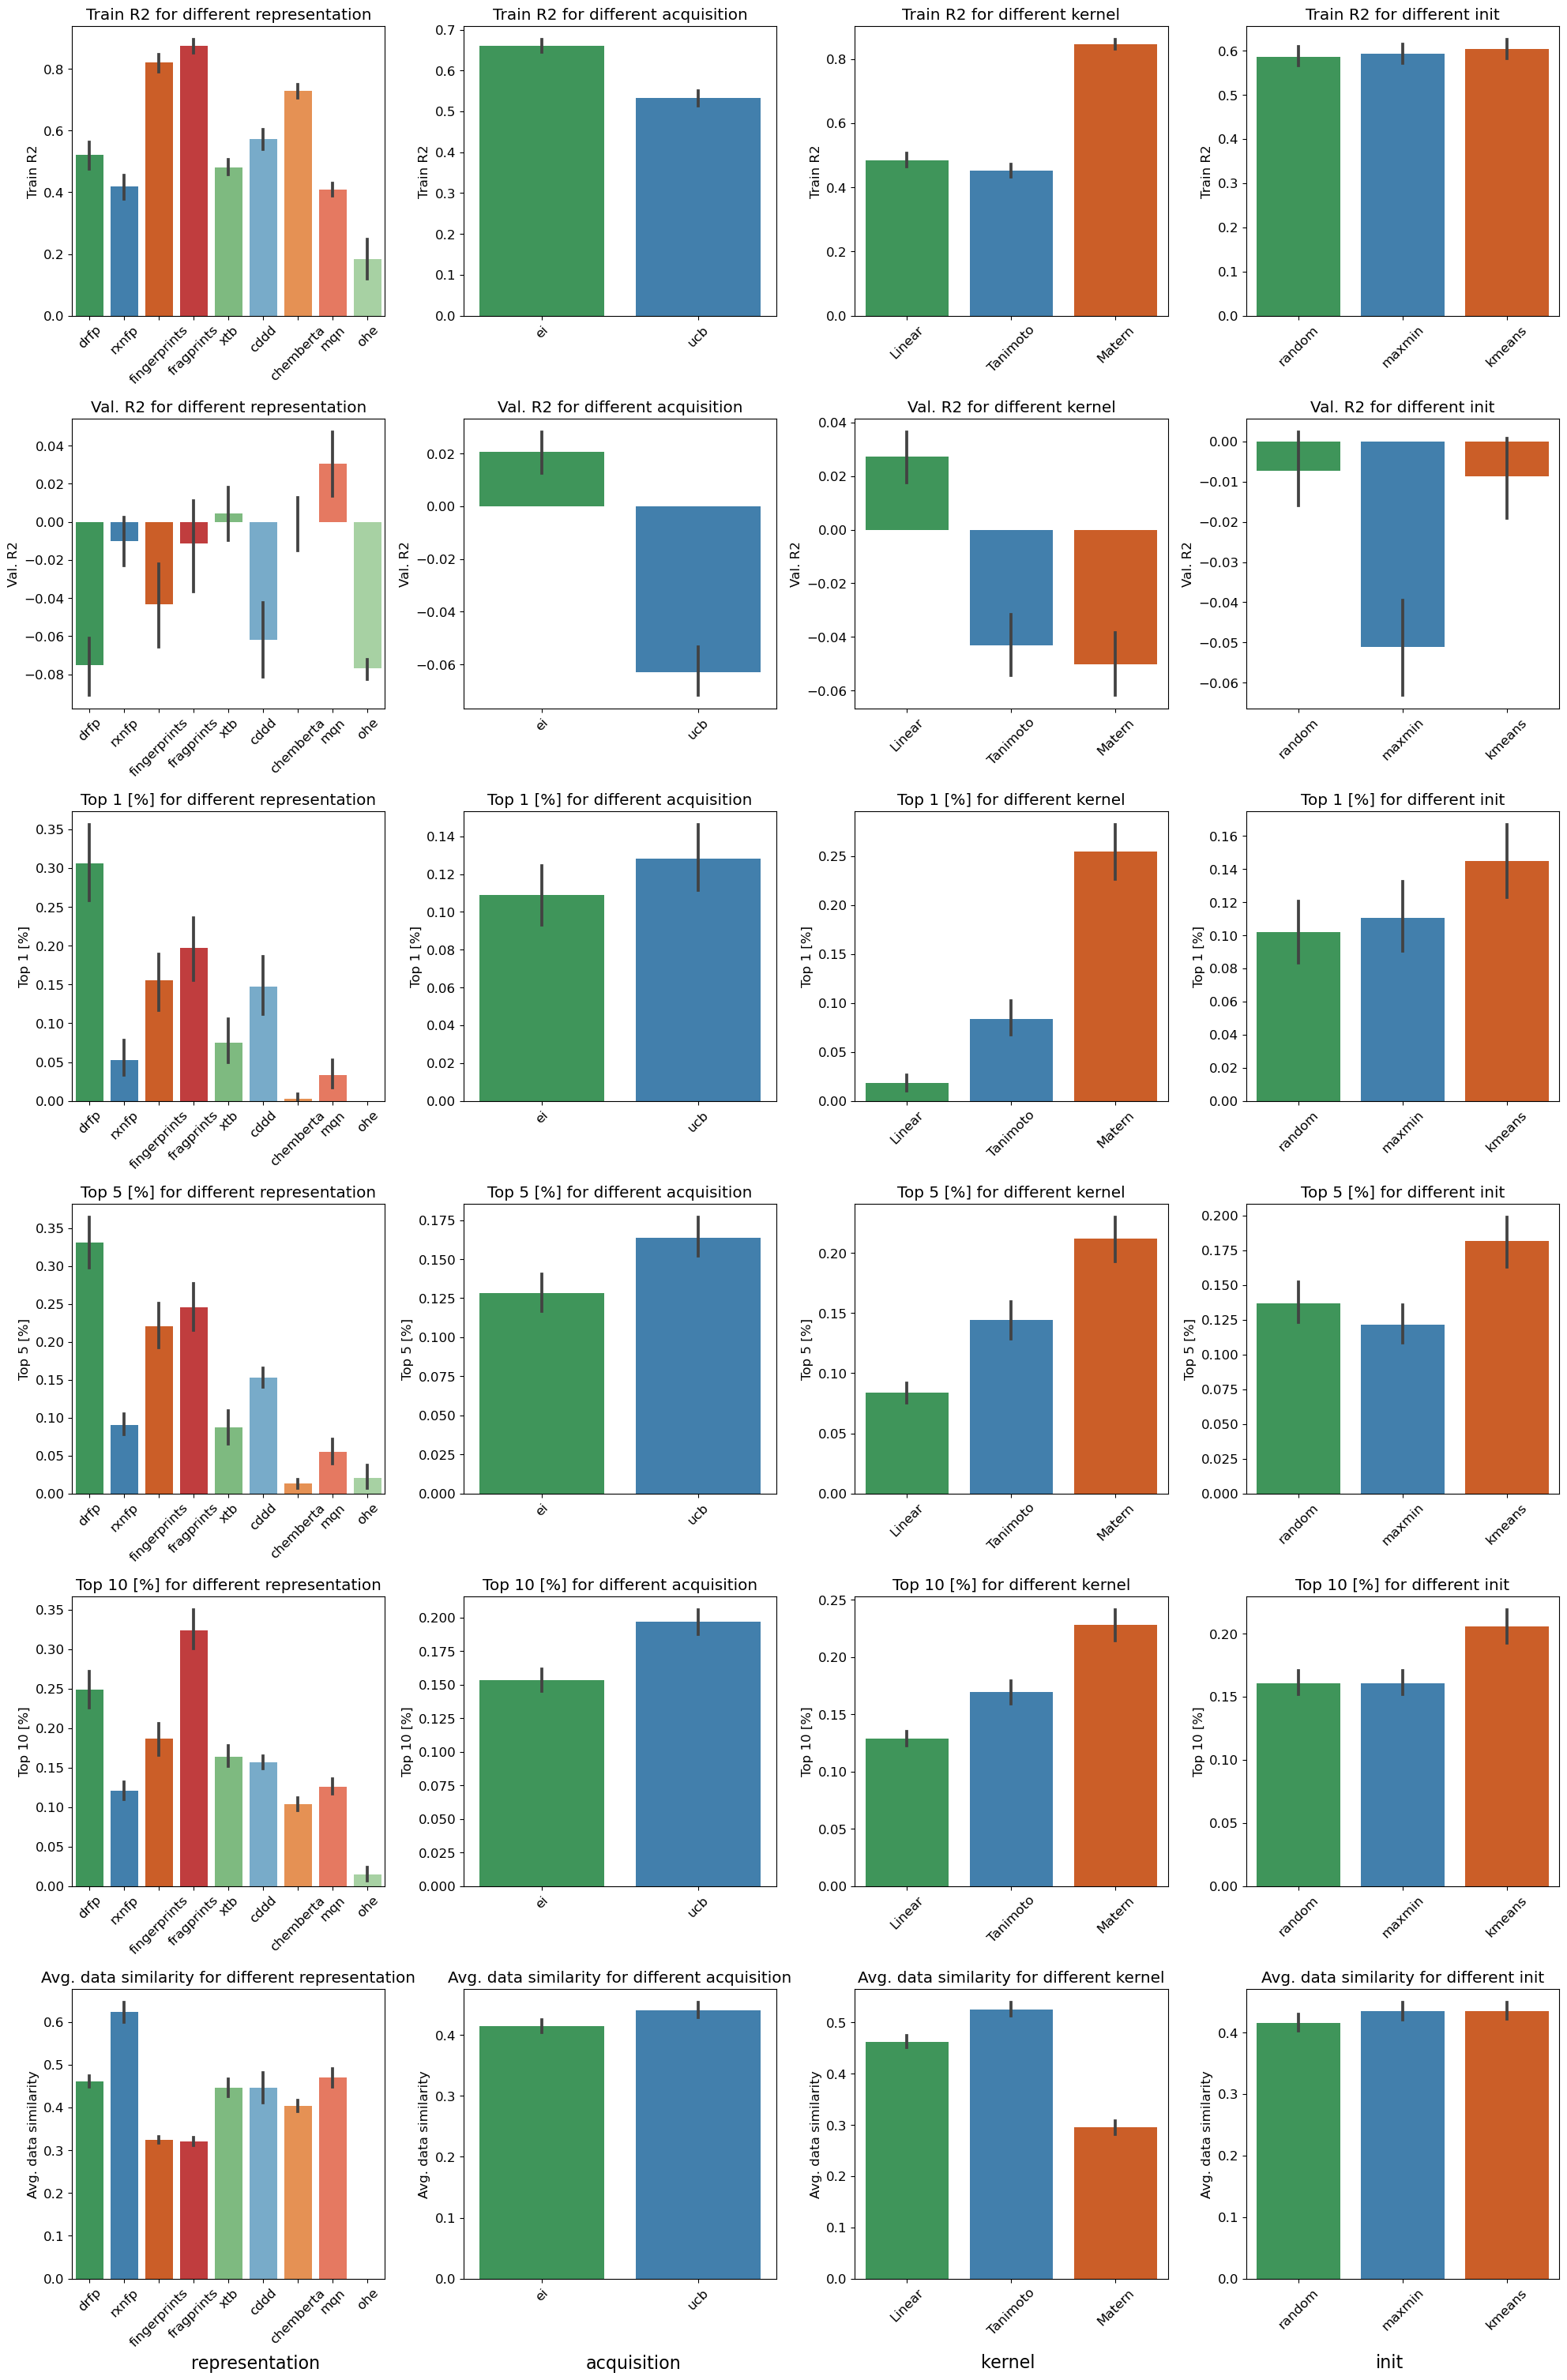

In [27]:
import json
import scipy.stats as stats
plt.rcParams.update({'font.size': 12})

parameters = [
    "representation",
    "acquisition",
    "kernel",
    "init",
]
metrics_to_analyze = [
    "train/r2",
    "valid/r2",
    "top_1_count",
    "top_5_count",
    "top_10_count",
    "average_similarity",
]

display_metrics = [
    "Train R2",
    "Val. R2",
    "Top 1 [%]",
    "Top 5 [%]",
    "Top 10 [%]",
    "Avg. data similarity",
]

supplementary_dir = "../report/supplementary/"
os.makedirs(supplementary_dir, exist_ok=True)

ks_results = {}


def bootstrapped_ks_test(data1, data2, n_iterations=100): 
    ks_stats = []
    for _ in range(n_iterations):
        sample1 = np.random.choice(data1, len(data1), replace=True)
        sample2 = np.random.choice(data2, len(data2), replace=True)
        _, p_value = stats.ks_2samp(sample1, sample2)
        ks_stats.append(p_value)
    return np.mean(ks_stats)



num_metrics = len(metrics_to_analyze)
fig, axs = plt.subplots(num_metrics, 4, figsize=(20, 5 * num_metrics))

for i, metric in enumerate(display_metrics):
    for j, parameter in enumerate(parameters):
        ax = axs[i, j]
        sns.barplot(x=parameter, y=metric, data=combined_data, ax=ax)
        ax.set_title(f"{metric} for different {parameter}")
        ax.set_xlabel("")
        ax.tick_params(axis="x", labelrotation=45)
        ax.set_ylabel(metric)

        # bootstrapped KS tests
        unique_values = combined_data[parameter].unique()
        y_max = ax.get_ylim()[1] #combined_data.groupby(parameter).max()[metric].max()
        # ks_results = {}
        # for idx1, val1 in enumerate(unique_values):
        #     for idx2, val2 in enumerate(unique_values):
        #         if idx1 >= idx2:
        #             continue  
        #         data1 = combined_data[combined_data[parameter] == val1][metric]
        #         data2 = combined_data[combined_data[parameter] == val2][metric]
        #         p_value = bootstrapped_ks_test(
        #             data1, data2, n_iterations=1000
        #         )  
        #         ks_results[f"{val1}_vs_{val2}"] = p_value

        #         # Check if p_value is below threshold and annotate
        #         if p_value < 0.05:
        #             y = y_max + 0.01 * (idx2 + idx2)  
        #             ax.plot([idx1, idx2], [y, y], color='k', linestyle='-', linewidth=1)
        #             ax.text((idx1 + idx2) * 0.5, y, '*', horizontalalignment='center')

        # ks_results[f"{metric}_{parameter}"] = ks_results

plt.tight_layout()
plot_path = os.path.join(
    supplementary_dir, "all_metrics_parameters.png"
)
for i in range(len(parameters)):
    fig.text(0.25*i+0.125, 0.00, parameters[i], va="center", fontsize=16)

plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()


### Multiple parameters importance

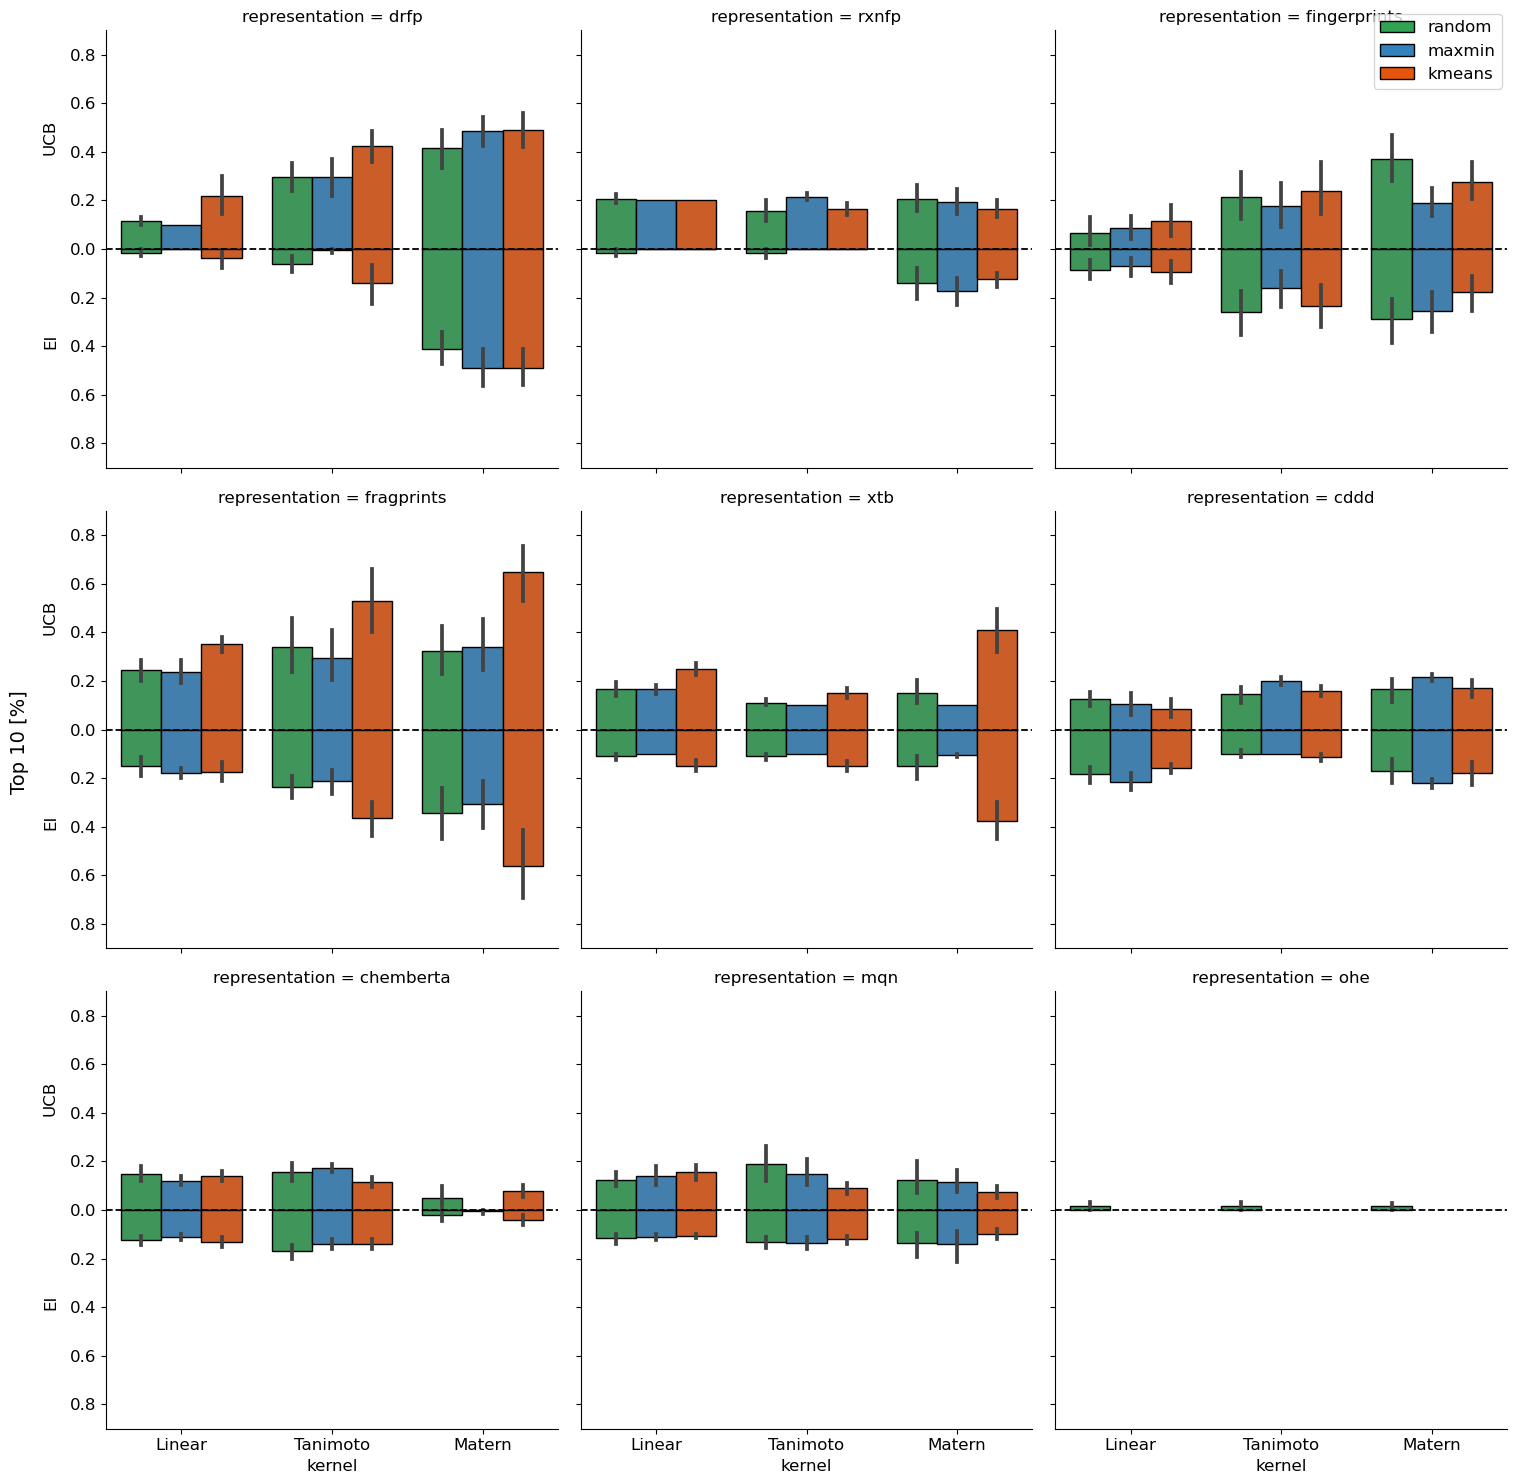

In [28]:
kernel_order = combined_data["kernel"].drop_duplicates().tolist()
init_order = combined_data["init"].drop_duplicates().tolist()
metric = 'Top 10 [%]'
g = sns.FacetGrid(combined_data, col="representation", col_wrap=3, height=5, aspect=1)
y_max = -np.inf
for i, ax in enumerate(g.axes.flat):
    representation = combined_data["representation"].drop_duplicates().iloc[i]
    subset_data = combined_data[combined_data["representation"] == representation]
    # UCB
    b1 = sns.barplot(
        x="kernel",
        y=metric,
        hue="init",
        data=subset_data[subset_data["acquisition"] == "ucb"],
        ax=ax,
        order=kernel_order,
        hue_order=init_order,
        edgecolor="black",
    )
    # EI as negative
    negative_data = subset_data[subset_data["acquisition"] == "ei"].copy()
    negative_data[metric] = -negative_data[metric]
    sns.barplot(
        x="kernel",
        y=metric,
        hue="init",
        data=negative_data,
        ax=ax,
        order=kernel_order,
        hue_order=init_order,
        edgecolor="black",
    )
 
    b1.get_legend().remove()

    # Set y-axis to be symmetric
    y_max = max(max(abs(subset_data[metric])), y_max)
    ax.set_ylim(-y_max, y_max)
    
    ticks = np.linspace(-0.8, 0.8, num=9)  
    labels = ["{:.1f}".format(abs(tick)) for tick in ticks]
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)



    ax.set_ylabel("")

    ax.axhline(0, color="black", linewidth=1.3, linestyle="--")

for i, ax in enumerate(g.axes.flat):
    if i % 3 == 0:  
        ax.annotate(
            "UCB",
            xy=(0, 0.5),
            xycoords="axes fraction",
            textcoords="offset points",
            xytext=(-40, 70),
            ha="center",
            rotation=90,
            fontsize=12,
        )
        ax.annotate(
            "EI",
            xy=(0, 0.5),
            xycoords="axes fraction",
            textcoords="offset points",
            xytext=(-40, -70),
            ha="center",
            rotation=90,
            fontsize=12,
        )


from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=pal_4_sorted[0], edgecolor="black", label=init_order[0]),
    Patch(facecolor=pal_4_sorted[1], edgecolor="black", label=init_order[1]),
    Patch(facecolor=pal_4_sorted[2], edgecolor="black", label=init_order[2]),
]
g.fig.text(
    -0.01, 0.5, "Top 10 [%]", va="center", rotation="vertical", fontsize=14
)
g.fig.legend(
    handles=legend_elements, loc="lower right", ncol=1, bbox_to_anchor=(0.99, 0.93)
)
g.fig.tight_layout()
plt.savefig(
    "../report/supplementary/facet_plot_all_params.png", dpi=300, bbox_inches="tight"
)
plt.show()

### BO vs GPR

20


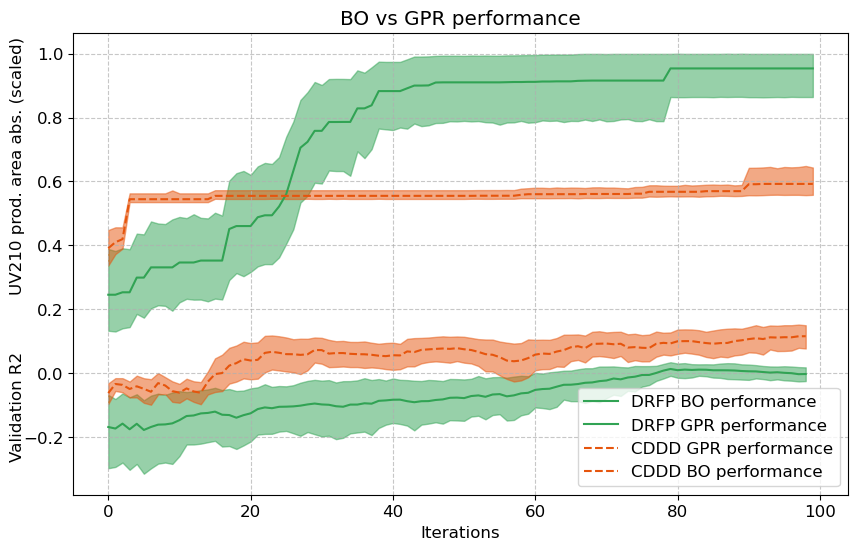

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plate = 1

#DRFP
for i, representation in enumerate(["drfp"]):
    run_ids = bo_paths_data[
        (bo_paths_data["representation"] == representation)
        & (
            bo_paths_data["data.data_path"]
            == f"data/additives/additive_rxn_screening_plate_{plate}.csv"
        )
    ]["run_id"].tolist()
    add_bo_path_to_plot(
        run_ids,
        metric="train/best_so_far",
        history_data=history_data,
        label="DRFP BO performance",
        ax=ax,
        linestyle="-",
        lw=1.5,
        alpha=0.5,
        color=full_palette[0],
        scale_to=[0, 1],
    )
    add_bo_path_to_plot(
        run_ids,
        metric="valid/r2",
        history_data=history_data,
        label="DRFP GPR performance",
        ax=ax,
        linestyle="-",
        lw=1.5,
        alpha=0.5,
        color=full_palette[0],
    )

# CDDD
run_ids = filter_data(
    data,
    {
        "representation": "cddd",
        "kernel": "Linear",
        "init": "kmeans",
        "acquisition": "ucb",
        "data.data_path": f"data/additives/additive_rxn_screening_plate_{plate}.csv",
    },
)["run_id"].tolist()
print(len(run_ids))
add_bo_path_to_plot(
    run_ids,
    metric="valid/r2",
    history_data=history_data,
    label="CDDD GPR performance",
    ax=ax,
    linestyle="--",
    lw=1.5,
    alpha=0.5,
    color=pal_4_sorted[2],
)

add_bo_path_to_plot(
    run_ids,
    metric="train/best_so_far",
    history_data=history_data,
    label="CDDD BO performance",
    ax=ax,
    linestyle="--",
    lw=1.5,
    alpha=0.5,
    color=pal_4_sorted[2],
    scale_to=[0, 1],
)

ax.annotate(
            "UV210 prod. area abs. (scaled)",
            xy=(0, 0.5),
            xycoords="axes fraction",
            textcoords="offset points",
            xytext=(-40, -20),
            ha="center",
            rotation=90,
            fontsize=12,
        )
ax.annotate(
            "Validation R2",
            xy=(0, 0.5),
            xycoords="axes fraction",
            textcoords="offset points",
            xytext=(-40, -140),
            ha="center",
            rotation=90,
            fontsize=12,
        )
ax.set_title("BO vs GPR performance")
ax.set_xlabel("Iterations")
ax.set_ylabel("")
ax.legend()
plt.savefig("../report/supplementary/bo-vs-gpr.png", dpi=300, bbox_inches="tight")
plt.show()

## Table 3 Supplementary material

In [35]:
display_metrics

['Train R2',
 'Val. R2',
 'Top 1 [%]',
 'Top 5 [%]',
 'Top 10 [%]',
 'Avg. data similarity']

In [32]:
agg_funcs = ['mean', 'std']
grouped_data = combined_data.groupby(['representation', 'kernel', 'init', 'acquisition'])[display_metrics].agg(agg_funcs).reset_index()
grouped_data.columns = ['_'.join(col).rstrip('_') for col in grouped_data.columns.values]
formatted_data = grouped_data[['representation', 'kernel', 'init', 'acquisition']].copy()
for metric in display_metrics:
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    formatted_data[metric] = grouped_data.apply(lambda row: f"{row[mean_col]:.2f} ± {row[std_col]:.2f}", axis=1)


In [30]:
formatted_data.to_csv('../report/supplementary/table_all_combinations.csv', index=False)

In [36]:
formatted_data.sort_values('Val. R2', ascending=False).head()

,representation,kernel,init,acquisition,Train R2,Val. R2,Top 1 [%],Top 5 [%],Top 10 [%],Avg. data similarity
0,cddd,Linear,kmeans,ei,0.84 ± 0.06,0.23 ± 0.03,0.00 ± 0.00,0.06 ± 0.09,0.16 ± 0.05,0.59 ± 0.04
4,cddd,Linear,random,ei,0.84 ± 0.06,0.21 ± 0.05,0.00 ± 0.00,0.08 ± 0.12,0.18 ± 0.07,0.58 ± 0.05
72,fragprints,Linear,kmeans,ei,0.85 ± 0.11,0.19 ± 0.07,0.00 ± 0.00,0.13 ± 0.18,0.17 ± 0.09,0.30 ± 0.02
141,xtb,Tanimoto,kmeans,ei,0.49 ± 0.03,0.15 ± 0.05,0.00 ± 0.00,0.10 ± 0.10,0.15 ± 0.05,0.62 ± 0.01
102,mqn,Tanimoto,kmeans,ei,0.46 ± 0.06,0.15 ± 0.02,0.00 ± 0.00,0.04 ± 0.08,0.12 ± 0.04,0.57 ± 0.01


In [37]:
df_multi_index = formatted_data.set_index(['representation', 'kernel', 'init', 'acquisition'])
latex_table_multi_index = df_multi_index.to_latex(index=True, na_rep='', multirow=True, longtable=True)

latex_table_file_path = '../report/supplementary/latex_table_grouped_by_all.txt'
with open(latex_table_file_path, 'w') as f:
    f.write(latex_table_multi_index)

/tmp/ipykernel_3013500/2653099570.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_multi_index = df_multi_index.to_latex(index=True, na_rep='', multirow=True, longtable=True)


In [38]:
def convert_to_mean(value):
    if isinstance(value, str):
        return float(value.split('±')[0].strip())
    return value

In [40]:
df_all = formatted_data.copy()
for metric in display_metrics:
    df_all[metric]=df_all[metric].apply(convert_to_mean)
df_all = df_all[df_all['kernel']=='Matern']

In [43]:
formatted_data.sort_values('Top 5 [%]', ascending=False).head()


,representation,kernel,init,acquisition,Train R2,Val. R2,Top 1 [%],Top 5 [%],Top 10 [%],Avg. data similarity
42,drfp,Matern,kmeans,ei,0.99 ± 0.06,-0.00 ± 0.07,0.80 ± 0.41,0.66 ± 0.27,0.49 ± 0.18,0.39 ± 0.10
43,drfp,Matern,kmeans,ucb,0.99 ± 0.06,-0.00 ± 0.06,0.75 ± 0.44,0.66 ± 0.26,0.49 ± 0.17,0.42 ± 0.10
45,drfp,Matern,maxmin,ucb,1.00 ± 0.00,0.04 ± 0.01,0.75 ± 0.44,0.65 ± 0.27,0.48 ± 0.15,0.49 ± 0.04
79,fragprints,Matern,kmeans,ucb,1.00 ± 0.00,-0.20 ± 0.25,0.70 ± 0.47,0.60 ± 0.33,0.65 ± 0.26,0.34 ± 0.08
44,drfp,Matern,maxmin,ei,1.00 ± 0.00,0.04 ± 0.03,0.60 ± 0.50,0.58 ± 0.27,0.49 ± 0.18,0.46 ± 0.04


# Analysis of BO results on Buchwald-Hartwig dataset

In [44]:
bh_data = pd.read_csv("../report/bh_1_summary.csv")
bh_data = format_results_data(bh_data)
bh_history_data = pd.read_csv("../report/bh_1_history.csv")


In [45]:
for metric in percentage_metrics:
    bh_data[metric] = bh_data.apply(
        lambda x: convert_to_percentage(x, metric), axis=1
    )

In [46]:
bh_data.rename(columns=dict(zip(metrics_to_analyze, display_metrics)), inplace=True)
bh_data['init'].replace({'true_random': 'random'}, inplace=True)


In [47]:
bh_data[bh_data['acquisition']=='ucb'].groupby('representation').count()

,_runtime,_step,_timestamp,_wandb.runtime,Avg. data similarity,batch_size,covar_module.base_kernel.lengthscale,covar_module.base_kernel.variance,covar_module.outputscale,data.data_path,data.featurizer.class_path,bond_radius,n_bits,data.featurizer.init_args.task,data.input_column,data.target_column,data_selection.init,init,data_selection.metric,data_selection.n_clusters,data_selection.use_pca,enable_logging_images,enable_plotting,epoch,finetuning,input_stat_feature_dimension,input_stat_n_points,likelihood.noise_covar.noise,mean_module.constant,acquisition,model.batch_size,model.beta,model.enable_logging_images,model.enable_plotting,model.finetuning,model.top_n,n_iters,n_trials,name,quantile_75_count,quantile_90_count,quantile_95_count,quantile_99_count,run_id,seed_everything,suggestion_idx,sum_acq_values,surrogate_model.class_path,surrogate_model.init_args.covar_module.class_path,kernel,surrogate_model.init_args.covar_module.init_args.base_kernel.init_args.eps,surrogate_model.init_args.covar_module.init_args.base_kernel.init_args.metric,surrogate_model.init_args.covar_module.init_args.base_kernel.init_args.nu,surrogate_model.init_args.covar_module.init_args.eps,surrogate_model.init_args.initial_lengthscale_val,surrogate_model.init_args.initial_noise_val,surrogate_model.init_args.initial_outputscale_val,surrogate_model.init_args.likelihood.class_path,surrogate_model.init_args.likelihood.init_args.batch_shape.class_path,surrogate_model.init_args.noise_constraint,normalize,surrogate_model.init_args.standardize,target_stat_max,target_stat_mean,target_stat_std,target_stat_var,Top 10 [%],Top 1 [%],top_3_count,Top 5 [%],top_n,train/best_so_far,train/mae,train/mse,train/msll,train/qce,Train R2,train/suggestion,trainer/global_step,valid/mae,valid/mse,valid/msll,valid/qce,Val. R2
representation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
drfp,360,360,360,360,360,360,120,120,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,0,120,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360,360
ohe,180,180,180,180,180,180,60,60,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,0,60,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180
rxnfp,180,180,180,180,180,180,60,60,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,0,60,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180


In [48]:
best_config_results, filtered_dataframes, combined_data = extract_filtered_data(
    data=bh_data,
    metrics_to_analyze=display_metrics,
    main_metric="Top 5 [%]",
    category="representation",
    base_filters={
        "kernel": ["Linear", "Matern", "Tanimoto"],
        "init": ["random", "kmeans", "maxmin"],
        "acquisition": ["ucb"],
        "data.data_path": "data/reactions/bh/bh_reaction_1.csv"
    },
    config_list=[
        {"name": "drfp", "columns": ["bond_radius", "n_bits"]},
        {"name": "rxnfp", "columns": ["normalize"]},
        {"name": "ohe", "columns": []},
    ],
)

In [49]:
best_config_results

{'drfp': {'Train R2': {'params': {'bond_radius': 7, 'n_bits': 512},
   'value': 0.9462564246013939},
  'Val. R2': {'params': {'bond_radius': 7, 'n_bits': 512},
   'value': 0.351509569126962},
  'Top 1 [%]': {'params': {'bond_radius': 5, 'n_bits': 2048},
   'value': 0.5611111111111111},
  'Top 5 [%]': {'params': {'bond_radius': 7, 'n_bits': 512},
   'value': 0.6777777777777778},
  'Top 10 [%]': {'params': {'bond_radius': 7, 'n_bits': 512},
   'value': 0.6727777777777777},
  'Avg. data similarity': {'params': {'bond_radius': 7, 'n_bits': 512},
   'value': 0.42696992689046365}},
 'rxnfp': {'Train R2': {'params': {'normalize': False},
   'value': 0.796387498554502},
  'Val. R2': {'params': {'normalize': False}, 'value': 0.3890156439328197},
  'Top 1 [%]': {'params': {'normalize': False}, 'value': 0.65},
  'Top 5 [%]': {'params': {'normalize': False}, 'value': 0.5211111111111111},
  'Top 10 [%]': {'params': {'normalize': False}, 'value': 0.4394444444444444},
  'Avg. data similarity': {'para

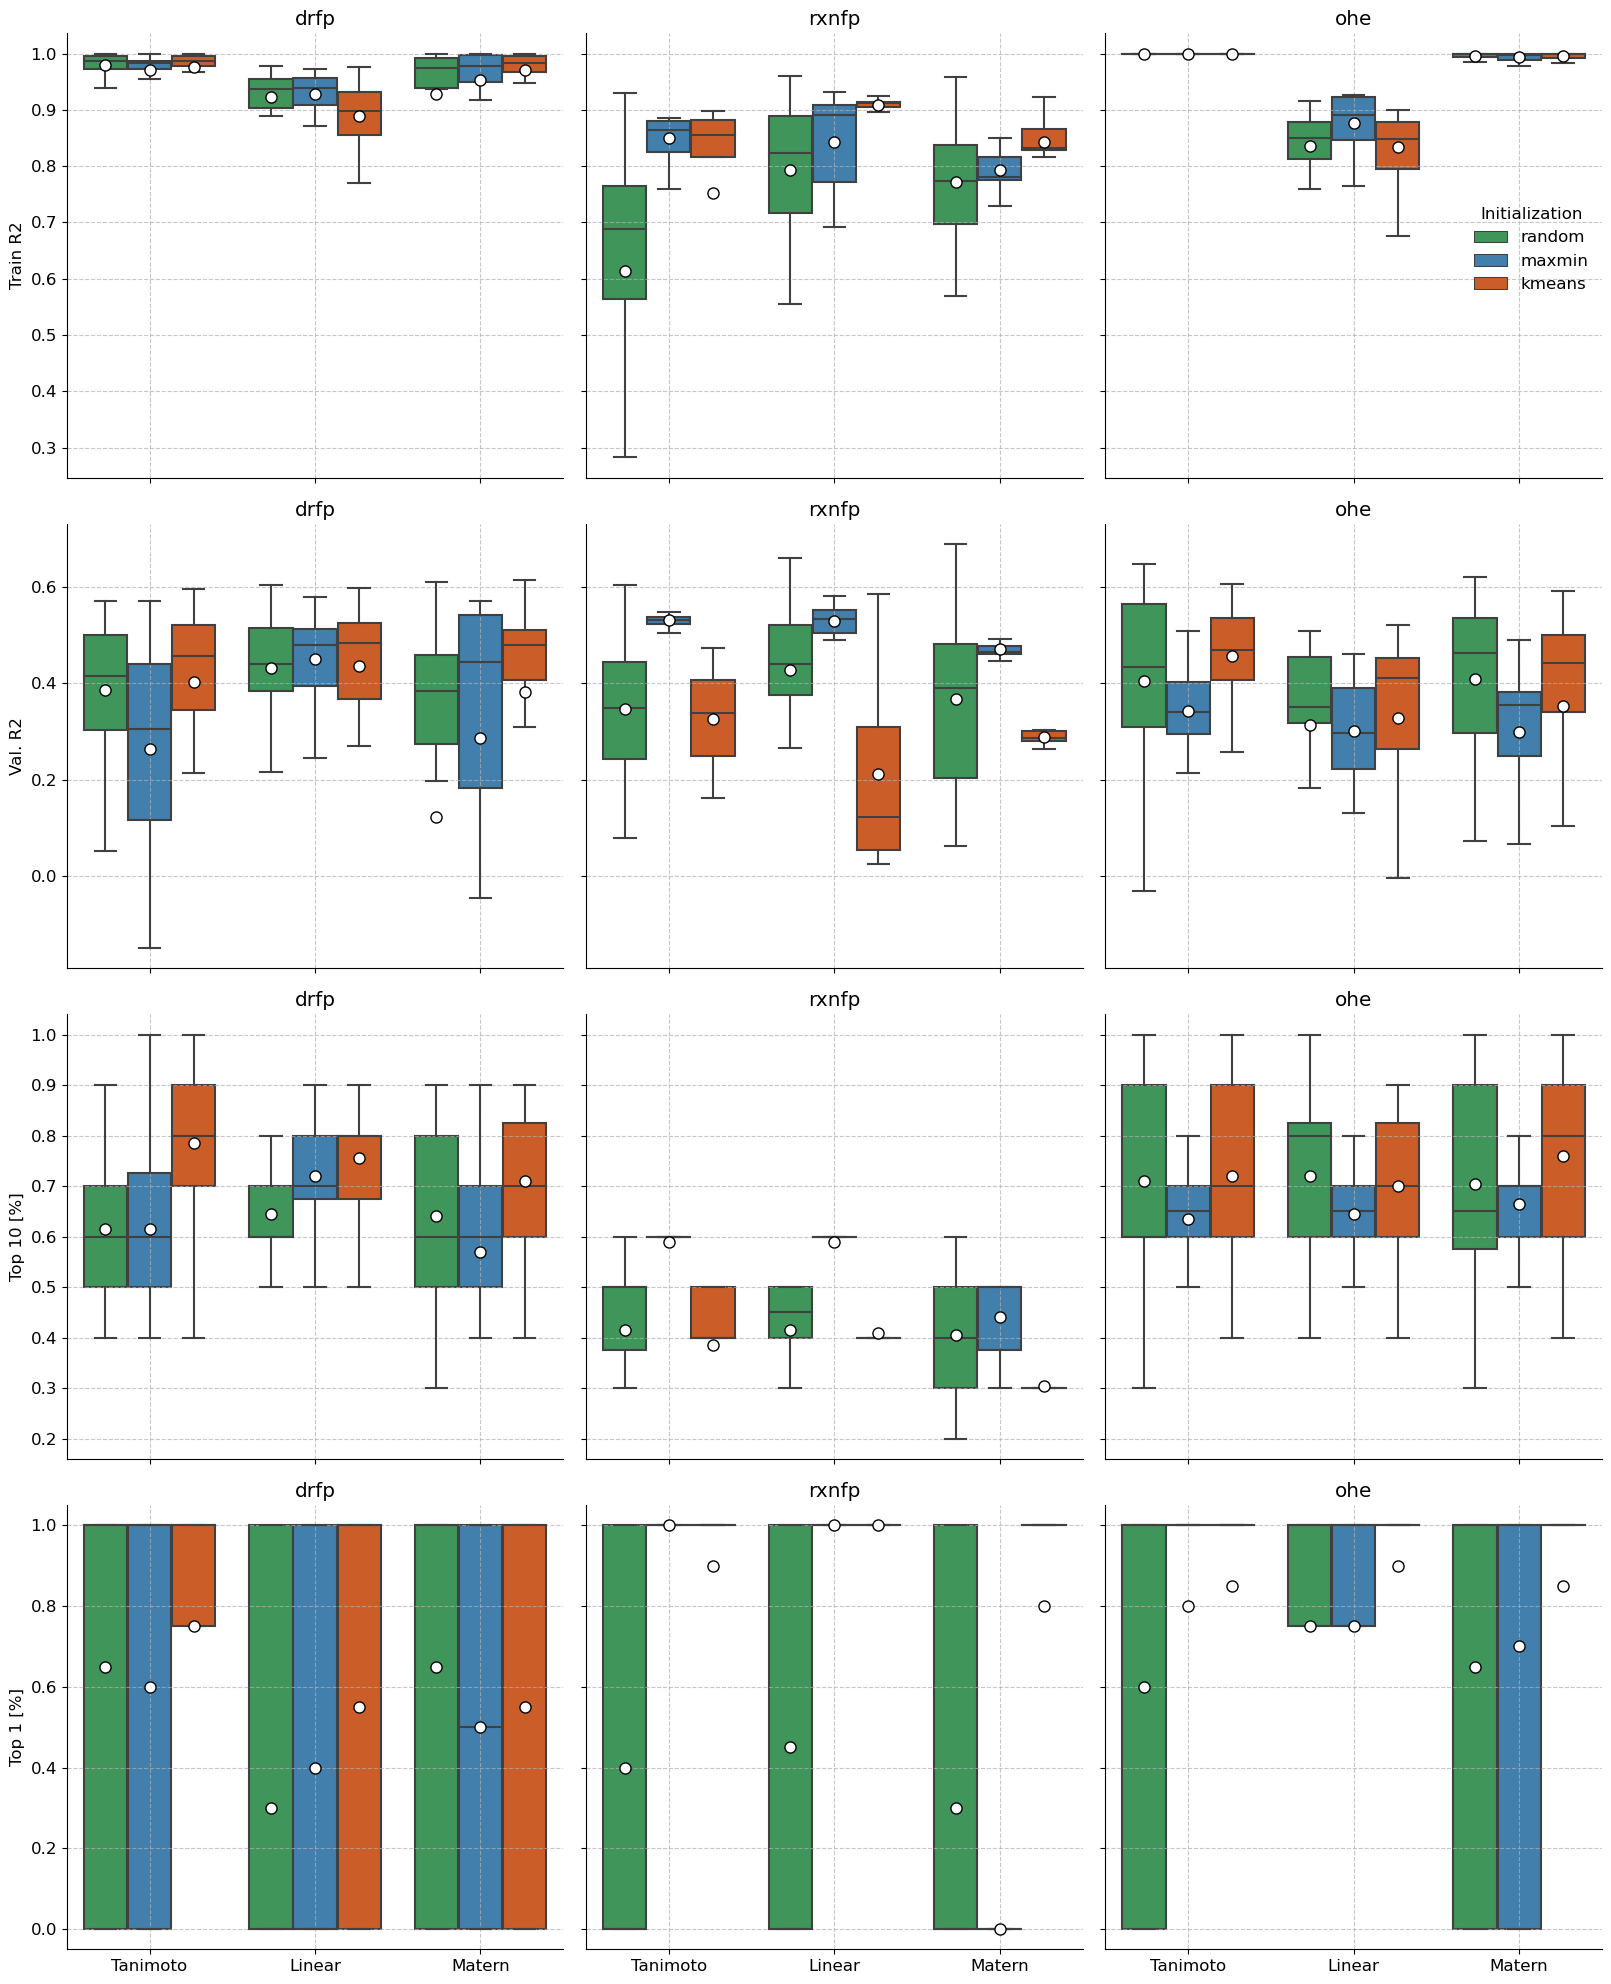

In [50]:
metrics_to_analyze = ['Train R2', 'Val. R2', 'Top 10 [%]', 'Top 1 [%]']
kernel_order = combined_data["kernel"].drop_duplicates().tolist()
init_order = combined_data["init"].drop_duplicates().tolist()

combined_data_melted = pd.melt(
    combined_data,
    id_vars=["representation", "kernel", "init", "acquisition"],
    value_vars=metrics_to_analyze,
    var_name="metric_type",
    value_name="metric_value",
)
g = sns.FacetGrid(
    combined_data_melted, col="representation", row="metric_type", height=5, aspect=1, sharey='row')
for i, ax in enumerate(g.axes.flat):
    col_name = combined_data_melted["representation"].drop_duplicates().iloc[i % len(kernel_order)]
    ax.set_title(col_name)

def barplot(x, y, hue, **kwargs):
    sns.boxplot(x=x, y=y, hue=hue, palette=full_palette, order=kernel_order,showfliers=False, showmeans=True, meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, **kwargs)
    plt.grid(True, alpha=0.7, linestyle="--")

g.map(barplot, "kernel", "metric_value", "init")

# Customize axes
g.set_axis_labels("", "")
g.set(ylabel="")

for ax in g.axes.flat:
    ax.legend().remove()
g.add_legend(title="Initialization", loc="upper right", ncol=1, bbox_to_anchor=(0.99, 0.90))
for ax, metric_type in zip(g.axes[:, 0], metrics_to_analyze):
    ax.set_ylabel(metric_type)


g.fig.tight_layout()

g.savefig("../report/supplementary/bh_facet_plot_all_params.png", dpi=300, bbox_inches="tight")
plt.show()



In [51]:
combined_data.groupby(['representation', 'kernel', 'init']).mean()['Top 10 [%]'].loc['drfp']

/tmp/ipykernel_3013500/3289713090.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined_data.groupby(['representation', 'kernel', 'init']).mean()['Top 10 [%]'].loc['drfp']


kernel    init  
Linear    kmeans    0.755
          maxmin    0.720
          random    0.645
Matern    kmeans    0.710
          maxmin    0.570
          random    0.640
Tanimoto  kmeans    0.785
          maxmin    0.615
          random    0.615
Name: Top 10 [%], dtype: float64

## Targeted inference analysis

In [68]:
top_data = pd.read_csv("../report/top_5_summary.csv")
top_history_data = pd.read_csv("../report/top_5_history.csv")
top_data = format_results_data(top_data)

In [69]:
for metric in percentage_metrics:
    top_data[metric] = top_data.apply(
        lambda x: convert_to_percentage(x, metric), axis=1
    )

In [70]:
y_max = top_data['target_stat_max'].values[0]


In [71]:
for column in ["MAE_top_5", "MAE_bottom_5", "MAE_all"]:
    top_data[column] = top_data[column].astype(float) / y_max


In [72]:
agg_funcs = ["mean", "std"]
metrics = [
    "NLPD_top_5",
    "NLPD_bottom_5",
    "NLPD_all",
    "MAE_top_5",
    "MAE_bottom_5",
    "MAE_all",
    "R2_top_5",
    "R2_bottom_5",
    "R2_all",
    "top_10_count",
    "top_1_count",
]
grouped_data = (
    top_data.groupby(["representation"])[metrics].agg(agg_funcs).reset_index()
)

grouped_data.columns = [
    "_".join(col).rstrip("_") for col in grouped_data.columns.values
]
formatted_data = grouped_data[["representation"]].copy()
for metric in metrics:
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"
    formatted_data[metric] = grouped_data.apply(
        lambda row: f"{row[mean_col]:.2f} ± {row[std_col]:.2f}", axis=1
    )

In [73]:
grouped_data.to_csv('../report/top_5_data.csv', index=False)

In [74]:
formatted_data.sort_values('NLPD_top_5', ascending=True)

,representation,NLPD_top_5,NLPD_bottom_5,NLPD_all,MAE_top_5,MAE_bottom_5,MAE_all,R2_top_5,R2_bottom_5,R2_all,top_10_count,top_1_count
3,fingerprints,11.25 ± 0.16,11.84 ± 0.70,11.49 ± 0.24,0.30 ± 0.04,0.42 ± 0.05,0.23 ± 0.01,-11.72 ± 2.73,-40168.52 ± 10663.23,-0.08 ± 0.14,0.05 ± 0.08,0.00 ± 0.00
2,drfp,11.32 ± 0.21,12.41 ± 1.02,11.48 ± 0.16,0.28 ± 0.05,0.45 ± 0.05,0.23 ± 0.01,-10.81 ± 3.60,-52927.59 ± 12596.21,-0.15 ± 0.18,0.11 ± 0.11,0.10 ± 0.31
4,fragprints,11.38 ± 0.08,11.49 ± 0.31,11.33 ± 0.07,0.35 ± 0.06,0.36 ± 0.06,0.22 ± 0.01,-22.00 ± 5.68,-31562.80 ± 10517.58,0.05 ± 0.05,0.29 ± 0.23,0.40 ± 0.51
7,rxnfp,11.57 ± 0.29,11.87 ± 0.56,11.58 ± 0.63,0.34 ± 0.05,0.41 ± 0.07,0.23 ± 0.00,-14.54 ± 5.19,-43367.71 ± 11241.50,-0.06 ± 0.04,0.00 ± 0.00,0.00 ± 0.00
8,xtb,11.64 ± 0.26,12.32 ± 0.80,15.22 ± 11.61,0.31 ± 0.05,0.43 ± 0.06,0.23 ± 0.01,-14.59 ± 3.89,-46680.24 ± 12840.86,-0.09 ± 0.13,0.14 ± 0.12,0.10 ± 0.31
0,cddd,13.46 ± 1.23,13.35 ± 1.34,11.81 ± 0.34,0.38 ± 0.05,0.38 ± 0.05,0.24 ± 0.00,-18.52 ± 5.09,-37257.40 ± 10686.25,-0.05 ± 0.07,0.03 ± 0.04,0.00 ± 0.00
5,mqn,14.13 ± 1.67,12.17 ± 0.82,12.73 ± 4.32,0.46 ± 0.04,0.30 ± 0.05,0.24 ± 0.01,-24.10 ± 4.42,-33511.04 ± 9509.74,-0.08 ± 0.09,0.00 ± 0.00,0.00 ± 0.00
6,ohe,15.27 ± 1.30,12.13 ± 0.49,11.95 ± 0.27,0.48 ± 0.05,0.29 ± 0.05,0.24 ± 0.01,-28.30 ± 5.56,-19381.08 ± 7197.95,-0.13 ± 0.13,0.02 ± 0.04,0.00 ± 0.00
1,chemberta,15.49 ± 0.82,11.69 ± 0.18,11.95 ± 0.18,0.51 ± 0.02,0.26 ± 0.02,0.25 ± 0.00,-32.34 ± 2.64,-12832.64 ± 3815.57,-0.20 ± 0.07,0.01 ± 0.02,0.00 ± 0.00


In [75]:
latex_table_top_5 = formatted_data.sort_values('NLPD_top_5', ascending=True).to_latex(index=False, na_rep='')

latex_table_file_path = '../report/supplementary/latex_table_top_5.txt'
with open(latex_table_file_path, 'w') as f:
    f.write(latex_table_top_5)

/tmp/ipykernel_3013500/2886943462.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_top_5 = formatted_data.sort_values('NLPD_top_5', ascending=True).to_latex(index=False, na_rep='')


## BO vs Random

In [223]:
from scipy.stats import ks_2samp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

_, _, bo_data = extract_filtered_data(
    data,
    {"kernel": "Matern", "acquisition": "ucb", "init": "kmeans"},
    display_metrics,
    "Top 5 [%]",
    representations_config[:-1],
    "representation",
)

In [243]:
bo_ys = []
for i in range(4):
    run_ids = bo_data[
            (bo_data["representation"] == 'drfp')
            & (
                bo_data["data.data_path"]
                == f"data/additives/additive_rxn_screening_plate_{i+1}.csv"
            )
        ]["run_id"].tolist()

    bo_suggestions = history_data[history_data["run_id"].isin(run_ids)]
    bo_y = bo_suggestions['train/suggestion']
    bo_ys.append(bo_y.values)

In [244]:
random_ys = []
for i in range(4):
    run_ids = filter_data(
            data,
            {
                "acquisition": "random",
                "data.data_path": f"data/additives/additive_rxn_screening_plate_{i+1}.csv",
            },
        )["run_id"].tolist()
    random_suggestions = history_data[history_data["run_id"].isin(run_ids)]
    random_y = random_suggestions['train/suggestion']
    random_ys.append(random_y.values)

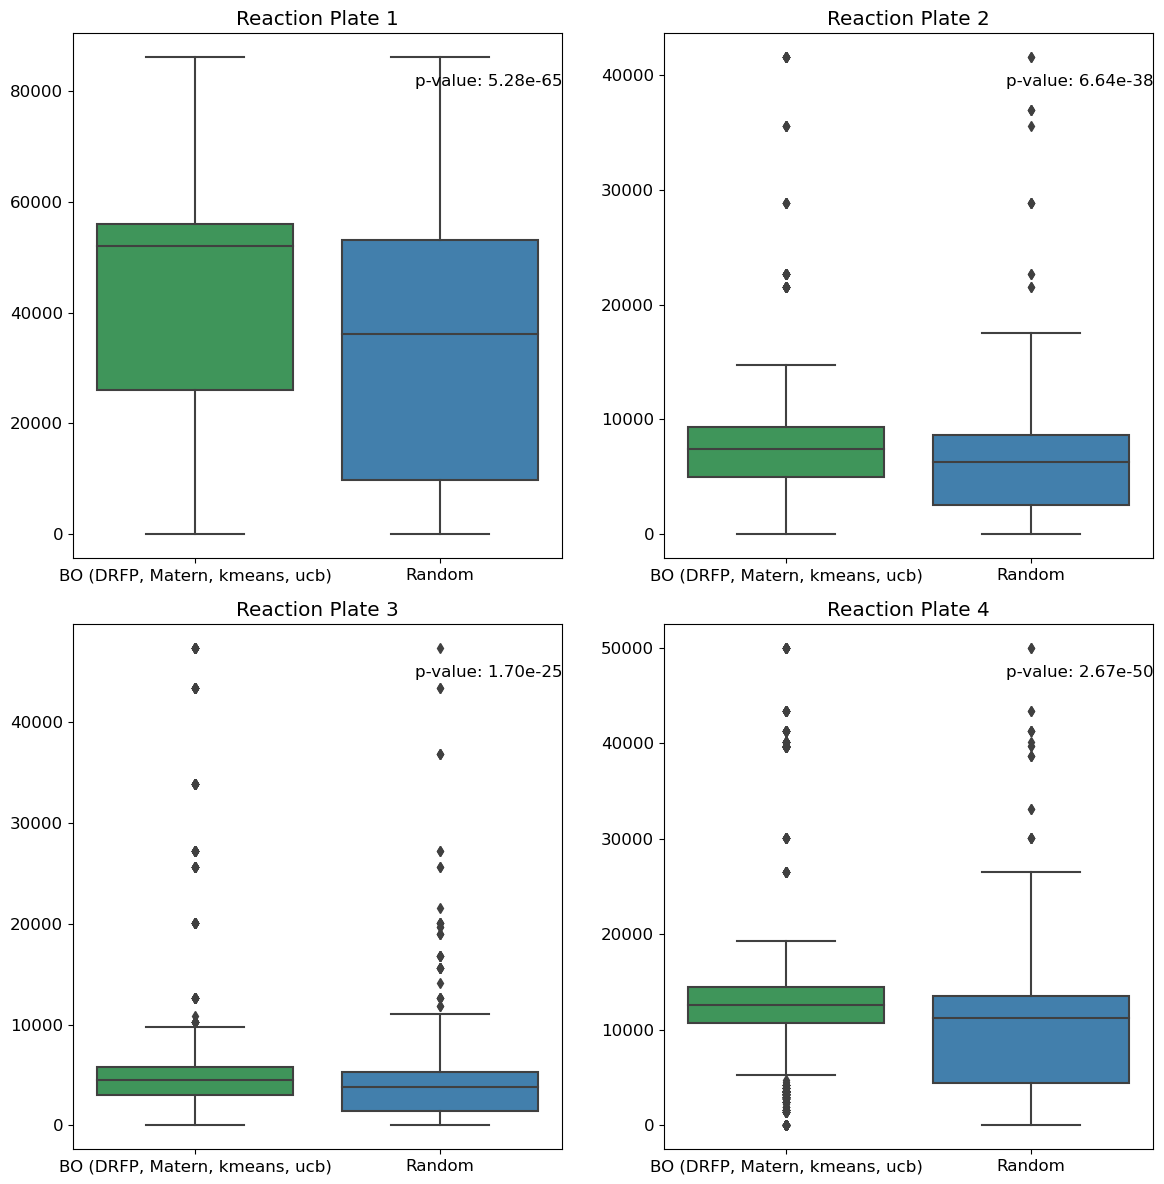

[5.282807573043857e-65,
 6.636101898269767e-38,
 1.7048781162309808e-25,
 2.6733536592291563e-50]

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

p_values = []

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, (bo_y, random_y, ax) in enumerate(zip(bo_ys, random_ys, axs)):
    sns.boxplot(data=[bo_y, random_y], ax=ax)
    ax.set_title(f'Reaction Plate {i+1}')
    ax.set_xticklabels(['BO (DRFP, Matern, kmeans, ucb)', 'Random'])
    
    _, p_value = ks_2samp(bo_y, random_y)
    p_values.append(p_value)
    
    ax.annotate(f'p-value: {p_value:.2e}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.savefig("../report/supplementary/bo-vs-random-ks-boot.png", dpi=300, bbox_inches="tight")

plt.show()
